# DBSPM: Basic Quick-Start Guide

This guide will help you run the python implementation of the Full Density Body Model on any machine with MPI. We also encourage you to check out the README file in the project directory to better understand each of the steps and the technical aspects of running `dbspm`.

## Requirements

Running dbspm requires the following programs and python modules:

- Standalone Programs
    - python (>=3.6)
    - openMPI
    - vasp (optional)
- python modules
    - numpy
    - scipy
    - pandas
    - ase
    - matplotlib
    - mpi4py
    - tricubic


### Environment Setup

To save some time later, we are going to add a variable needed for ASE to know the location of the vasp pseudopotentials. So, we also need to add in `~/.bashrc` the following line:

`export VASP_PP_PATH="/apps/exported/installed/software/vasp/PP/"`



## First steps

We are going to begin this guide by setting up our sample and input file for `dbspm`.

### 1. Setting up the calculation
#### 1.1 Putting a POSCAR in the ./sample subdir

First, we need to put our sample xyz-coordinates and simulation cell in a vasp `POSCAR` file inside the `./sample/` subdir. For this tutorial, there should be already one in said subdir. If it is not there, now is the time to put yours.

Now we are going to visualize the sample we are putting in with the help of ASE.

In [1]:
from ase.io import read
sample = read('sample/POSCAR')

In [2]:
print(sample)

Atoms(symbols='C36H16', pbc=True, cell=[18.0, 24.0, 17.999999999999996])


In [3]:
sample.positions

array([[ 9.01057584, 13.42270771,  2.96332544],
       [ 9.01330049, 14.84455978,  2.96332544],
       [10.24380675, 12.70576768,  2.96332544],
       [ 7.7746908 , 12.71010377,  2.96332544],
       [10.25484815, 15.56406244,  2.96332544],
       [ 7.77435645, 15.56823032,  2.96332544],
       [11.47768271, 13.43500855,  2.96332544],
       [ 6.54341188, 13.44344889,  2.96332544],
       [11.4612154 , 14.83555761,  2.96332544],
       [ 6.56520861, 14.84414612,  2.96332544],
       [10.24792637, 11.27850388,  2.96332544],
       [ 7.76550512, 11.28277916,  2.96332544],
       [ 9.00546696, 10.56811858,  2.96332544],
       [10.22826215, 16.98288558,  2.96332544],
       [ 7.80661806, 16.98695182,  2.96332544],
       [12.69708338, 12.69644278,  2.96332544],
       [ 5.32125495, 12.70929059,  2.96332544],
       [11.48864061, 10.57162239,  2.96332544],
       [ 6.52226807, 10.58012629,  2.96332544],
       [ 9.01862682, 17.67376641,  2.96332544],
       [12.69536977, 11.32556398,  2.963

<Axes: >

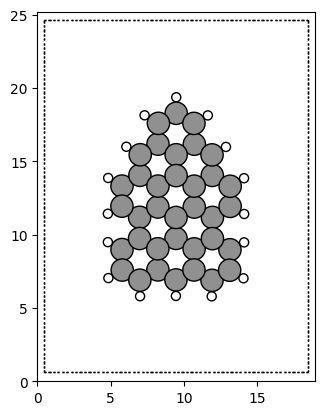

In [4]:
from ase.visualize.plot import plot_atoms
plot_atoms(sample)

#### 1.2 Input file for DBSPM

Now that we corroborated the sample we are going to use, it is time to setup our calculation with the help of an input file. The input is just a plain-text file that, for this guide, we are going to call `input.in`. In this file, each flag or variable should be in ALL-CAPS followed by an equal sign flanked by at least one blank space on each side (` = `), and the value should be in python format (except for strings that should not have quote marks ' or ").

Please check out the `input.in` file provided with this guide for reference. The basic settings in the file are the following:

- LABEL
    - String to label all the output files of dbspm.
- Z0 / ZF
    - Smallest (Z0) and largest (ZF) tip-sample separation in the calculation
- ZREF
    - Position along the z-axis of the sample
- ALPHA / V
    - Parameters for the short-range interaction

## Calculations

All calculations are done with the `dbspm`executable. Each of the following steps are a subprogram that can be run indepentently or in different gropings. See the `README` file for more information.

### 2. DFT calculations
#### 2.1 Sample calculations

Our first calculation is going to be the DFT properties (charge and potential) needed for the short-range and electrostatic interactions. This consist on a single scf calculation for the charge density (`CHGCAR`) and a potential-correcting calculation for the potential (`LOCPOT`).

DBSPM automates these two calculations with the help of the ASE interface with vasp. To run them, we use the `dbspm` executable with the `sample` flag. For example:

> dbspm sample -i input.in

This will read the `POSCAR` in `./sample`, do the scf calculation inside, and the potential calculation in `./sample/LDIPOL`.

#### 2.2 Tip calculation

Next, the charge density of the tip is calculated in a similar manner:

> dbspm tip -i input.in

This will read the `POSCAR` in the sample subdir, take the cell dimensions of the sample, and do a single scf calculation of a CO molecule in a cell of the same dimensions, all in the `./tip` subdir.

### 3. Files preparation

We need to prepare the `CHGCAR` `POTCAR` files for quick reading before proceeding for the FDBM calculations. This is done in the `grid` step:

> dbspm grid -i input.in

This will read the `CHGCAR` and `POTCAR` of the sample and put them in a binary numpy file (`./sample/sample.npz`), and then read the tip `CHGCAR` and save it (`./tip/tip.npz`).

We can also perform the steps described in 2 and 3 at the same time and prepare the calculation with a *step_alias*. For this, you should run:

> dbspm fullprep -i input.in

Now, we are going to check the sample numpy file to review its contents.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
samp_data = np.load('sample/sample.npz')
print(samp_data.__dict__['files'])

['rhoS', 'potS', 'shape', 'span', 'origin', 'ortho', 'cell', 'numbers', 'positions', 'zref']


The loaded numpy file works as a dictionary object so we can access any of the saved arrays using the keys shown above.

- **rhoS and potS** contain the sample charge density and local potential, respectively
- **span and origin** have the necessaty information to construct the 2D grids with tthe coordinates for all of the data points in the xy-plane
- **dr** is an array with [dx, dy, dz]
- **cell**, (atomic) **numbers**, and **positions**, contain the information of the cell and every atom in the sample
    - They can also be used to create an atoms ASE object

So, with the help of pyplot and the x/y coordinates we can visualize the sample charge density and potential.

First, we will use the `Grid` object to create the 2D grid with the coordinates for all of the data points in the xy-plane:

In [7]:
import sys
sys.path.append('/home/jtrujillo/DBSPM')
from pydbspm.grid import Grid

In [8]:
samp_grid = Grid(samp_data['shape'], span=samp_data['cell'], origin=samp_data['origin'], zref=3.0)

In [9]:
samp_grid.set_density('rhoS', samp_data['rhoS'], safe=True)

In [10]:
samp_grid.set_density('potS', samp_data['potS'], safe=True)

In [11]:
def nz(z, zref=3.0, dz=samp_grid.dr[2]):
    nz = np.rint((z+zref)/dz)
    return int(nz)

And then we plot the xy-plane with contourf:

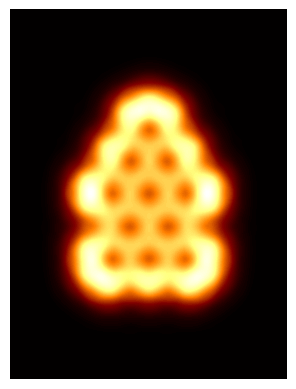

In [12]:
fig, ax = plt.subplots(1)
ax.contourf(
            samp_grid.x, samp_grid.y,
            samp_data['rhoS'][...,nz(3.0)],
            levels=128,
            cmap='afmhot'
            )
ax.set(aspect='equal')
ax.axis('off')
plt.show()

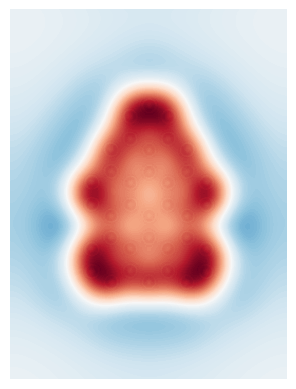

In [13]:
fig, ax = plt.subplots(1)
d = np.gradient(samp_data['potS'], -samp_grid.dr[2], axis=2)[...,nz(3)]
vmax = np.max(np.abs(d))
vmin = -vmax
ax.contourf(
            samp_grid.x, samp_grid.y,
            d,
            levels=128,
            vmin=vmin, vmax=vmax,
            cmap='RdBu_r'
            )
ax.set(aspect='equal')
ax.axis('off')
plt.show()

### 4. FDBM calculation
#### 4.1 Short range and electrostatic interactions

The `sr` step calculates the short range and `es` the electrostatic interactions. They read all the required parameters from the input file, although, the $\alpha$ for the SR can be overridden with the `-a` option. This script can be simply run with:

> dbspm sr -i input.in
> dbspm es -i input.in

or alternatively, for both, with the `dens` step:

> dbspm dens -i input.in

It is important to emphasise that the $\alpha$ can only be changed by running this script again, but the $V$ is applied in step 4.3.

The short-range and electrostatic interactions are saved to `label_sr_ax.xx.npz` and `label_es.npz`, respectively. 

#### 4.2 Van der Waals interaction

This interaction is calculated with Grimme's DFT-D3, which is a semi-empirical compliment to the dispersion missing in DFT. This 1 of 2 steps that require code parallelization for a quick calculation. This is achieved by performing the step with MPI:

> mpirun -np n dbspm vdw -i input.in

where n is the number of cores allocated for the calculation.

This calculation should write a `label_vdw.npz` file.

#### 4.3 Tip relaxation

Finally, we are going to combine all three interactions and calculate the minimum-energy tip position for every point of our 3D image grid. This is done in the `relax` step, which is run in a similar way to the one in point 4.2:

> mpirun -np n dbspm relax -i input.in

In this step, the $V$ scaling parameter is applied to the short range interaction, the interactions are summed up, and the tip position is minimized from the top of the 3D grid (furthest tip-sample separation) to the bottom of the grid for every point in the image.

The result is saved in a file named `relax_label_kx.xx_ay.yy_Vzz.zz.npz`, where $k$ is the effective spring-lever constant for CO, and $a$ and $V$ are the short range calculation parameters.

### 5. Checking the results

Now that we have all three interactions and the relaxed-tip result, we are going to learn how to use the AFMGrid class to read, interpret, and show the results.

#### 5.1 The AFMGrid class

AFMGrid requires two arguments, the **npz file** (or its path string) with the data, and the **key** of the property to read from the npz file ('E' for the interactions). It is also important to now the `zref` option. If it is not specified, AFMGrid will first try to get it from the npz file, then from the atoms mean z-positions (if an atoms object is passed with the `atoms` option), or it defaults to 0.0. In this case, it will read it from the npz file.

In [14]:
from pydbspm.SPMGrid import SPMGrid

For all of this interactions we will need to obtain the first derivative of the potential along the negative z direction. This can be automatically done with AFMGrid.

In [15]:
sr = SPMGrid('triangulene_sr_a1.08.npz', 'sr').get_gradient()
es = SPMGrid('triangulene_es.npz', 'es').get_gradient()
vdw = SPMGrid('triangulene_vdw.npz', 'vdw').get_gradient()
relax = SPMGrid('relax_triangulene_k0.2000_a1.08_V42.91.npz', 'E').get_gradient()

In [16]:
sr.data.shape

(240, 320, 54)

In [17]:
samp_grid.set_density('sr', sr.data, safe=True)

Also, its a good idea to multiply the sr interaction by its $V$ at this point.

In [18]:
sr *= 42.91

Furthermore, now that we have this 3 interactions we can plot what we call the *static* image. This is just the sum of the 3 interactions without the tip relaxation. With AFMGrid we can do this by simply adding up each of the interactions:

In [19]:
static = sr + es + vdw

We can corroborate the information in the new object just by using the print function

In [20]:
print(static)

STMGrid(Label: grad(sr), z-min: 2.4750, z-max: 6.4500, dz: 0.0750, zref: 3.0000, min. value: -1.09e-01, max. value: 8.59e-01)


#### 5.2 Plotting with SPMGrid

The SPMGrid class permits very straight-forward and quick plotting by just specifying the desired tip-sample distance:

<Axes: >

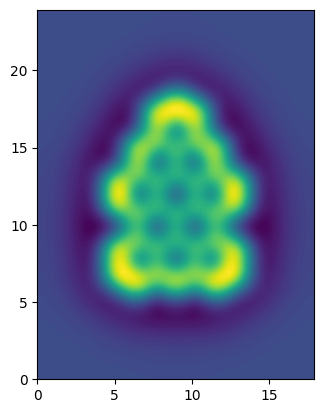

In [21]:
static.plot(3)

The SPMGrid.plot function accepts many useful options (and any pyplot.contourf options) like the ones used next:

z=3.2250, min=-4.8381e+01pN, max=4.5268e+01pN, range=9.3649e+01pN


<Axes: >

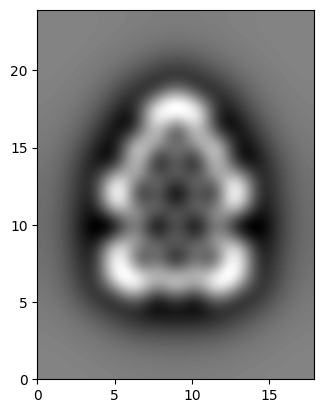

In [22]:
static.plot(3.2,
            # xlim=(2,12), ylim=(2,12), #plot limits
            cmap='gray', #pyplot colormap to use
            info=True, #prints the image information
            conv=1602, #set a conversion factor for the image units, ev/A by default
            units='pN', #units to print
            #text=True, #overlay the min-max values in the image
            color='w' #text color to improve contrast
           )

Furthermore, SPMGrid.plot can take a pyplot ax object to integrate into pyplot figures:

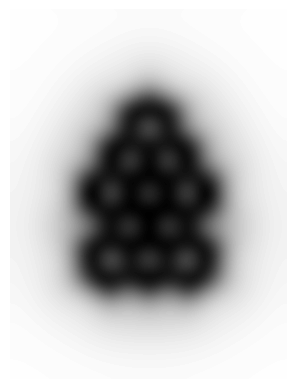

In [23]:
fig, ax = plt.subplots(1)
# ax.set_title('Relax Image')
es.plot(3.2, ax=ax, cmap='gray')
# ax.set_xlim(2,12)
# ax.set_ylim(2,12)
ax.set(aspect='equal')
ax.axis('off')
plt.show()

With this functionality, we can build useful figures to present our data:

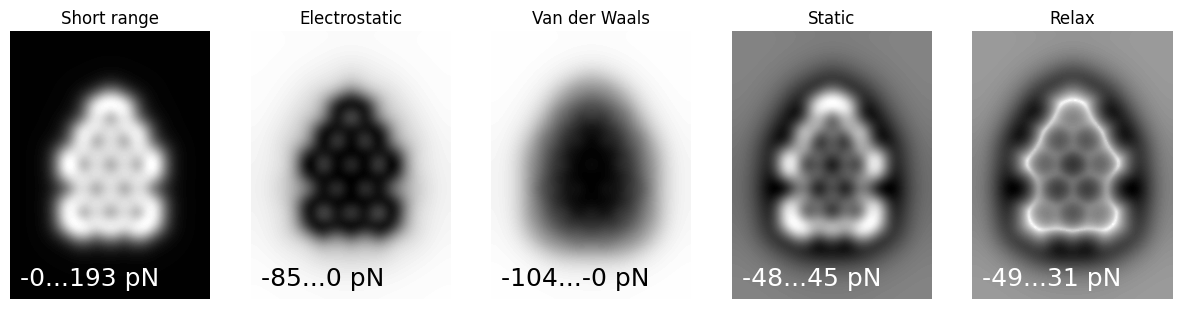

In [ ]:
z = 3.2
params = dict(
    xlim=(0,20),
    ylim=(0,25),
    cmap='gray',
    conv=1602,
    units='pN',
    text=True
)
fig, ax = plt.subplots(1, 5, figsize=(15,5), squeeze=True, subplot_kw={'aspect':'equal'})
ax[0].set_title('Short range')
sr.plot(z, ax=ax[0], color='w', **params)
ax[1].set_title('Electrostatic')
es.plot(z, ax=ax[1], color='k', **params)
ax[2].set_title('Van der Waals')
vdw.plot(z, ax=ax[2], color='k', **params)
ax[3].set_title('Static')
static.plot(z, ax=ax[3], color='w', **params)
ax[4].set_title('Relax')
relax.plot(3.2, ax=ax[4], color='w', **params)
for a in ax:
    a.axis('off')

#### 5.3 Other useful SPMGrid functions

- Adding an atoms object

By adding the atoms attribute to an SPMGrid object, we can overlay the atomic positions to any image we plot with said SPMGrid object. The atoms attribute can be set with `atoms=Atoms` when first creating the SPMGrid object, or later by explicitly setting `SPMGrid.atoms = Atoms`.

In [25]:
relax.atoms = sample

z=3.1500, min=-4.9439e+01pN, max=3.3814e+01pN, range=8.3253e+01pN


<Axes: >

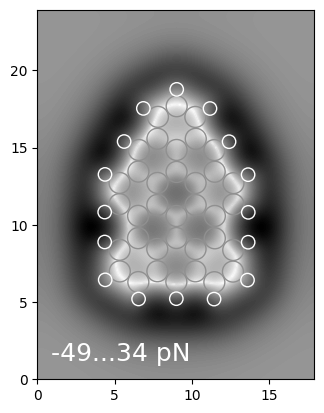

In [26]:
relax.plot(3.15,
            xlim=(0,20), ylim=(0,25), #plot limits
            cmap='gray', #pyplot colormap to use
            info=True, #prints the image information
            conv=1602, #set a conversion factor for the image units, ev/A by default
            units='pN', #units to print
            text=True, #overlay the min-max values in the image
            color='w', #text color to improve contrast
            show_atoms=True, #overlay atomic positions
            atoms_size=300 #atoms size
           )

### 7.1 Frequency shift
Now that we now that image is relaxed we can easily calculate the frequency shift with the `get_fs` method.

This method takes as input the amplitude ($A$) and can optionally take the cantilever resonant frequency (`f0`) and its spring constant (`k0`), which have a default value of $30300Hz$ and $1800N/m$ respectively.

The method returns an AFMGrid object with the corresponding `amp`, `f0`, and `k0` information as attributes, and the z-coordinates correspond to the closest tip-sample approach distance.

So, to obtain a frequency shift image with an amplitude of 0.6Å (that is 1.2Å peak-to-peak) we just run:

In [27]:
fs = relax.get_fs(0.6, verbose=True)

Selected semi-amplitude as multiple of dz: 8.0*dz = 0.6000 (1.2000 peak-to-peak)


With the current force-to-frequency shift methodology, the calculated grid will be reduced along the z-axis by the peak-to-peak amplitude distance.

Finally, we can plot the static, relaxed, and frequency shift images side by side:

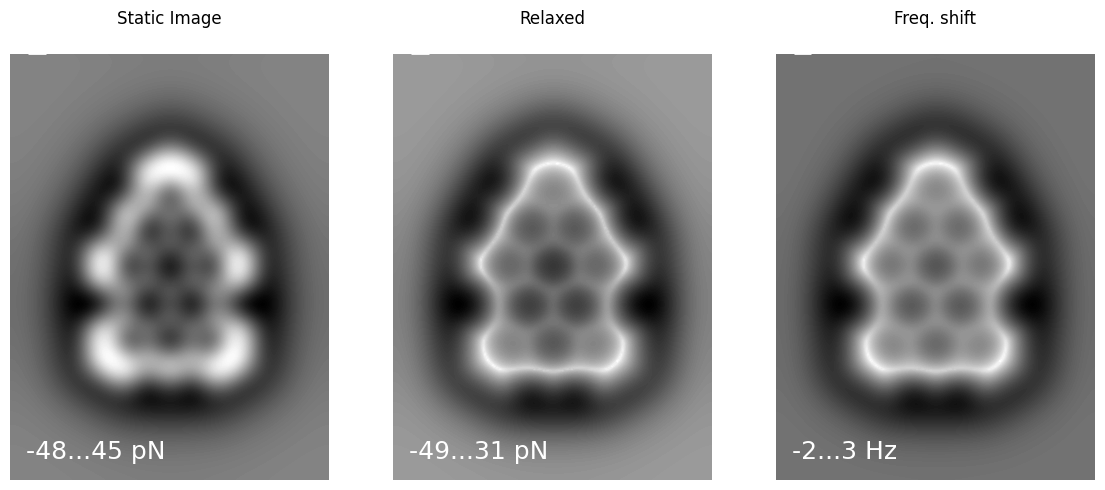

In [28]:
xlim = (0,20); ylim = (0,25)
params = {'xlim':xlim, 'ylim':ylim,
          'text':True, 'scalebar':1, 'color':'w', 'cmap':'gray'}
fig, ax = plt.subplots(1, 3, figsize=(14,7), squeeze=True, subplot_kw={'aspect':'equal'})
ax[0].set_title(r'Static Image')
static.plot(3.2, ax=ax[0], conv=1602, units='pN', **params)
ax[1].set_title(r'Relaxed')
relax.plot(3.2, ax=ax[1], conv=1602, units='pN', **params)
ax[2].set_title(r'Freq. shift')
fs.plot(3.2, ax=ax[2], units='Hz', **params)
for a in ax:
    a.axis('off')
plt.show()

### 8. BRSTM calculation
#### 8.1 STM

The `stm` step calculates the STM *s* and *p*-wave components. The bias potential is indicated with the option `-b` (in V):

> dbspm stm -i input.in -b 1.5

The stm is saved to `stm_label_Vx.xxx.npz`. 

#### 4.2 BRSTM

The `brstm` approximates the bond-resolved STM signal with the HR-AFM and STM data. Again, the stm bias potential is indicated with the option `-b` (in V):

> dbspm brstm -i input.in -b 1.5

This calculation should write a `brstm_label_Vx.xxx.npz` file.

In [29]:
from scipy.ndimage import gaussian_filter

In [30]:
stm = np.load('stm_triangulene_V1.500.npz')
stm_s = SPMGrid(stm['s'],'sp',atoms=read('sample/CONTCAR'),grid_from_atoms=True)
stm_p = SPMGrid(gaussian_filter(stm['p'],sigma=2,mode='wrap'),'p',atoms=read('sample/CONTCAR'),grid_from_atoms=True)
stm = stm_s + stm_p

<Axes: >

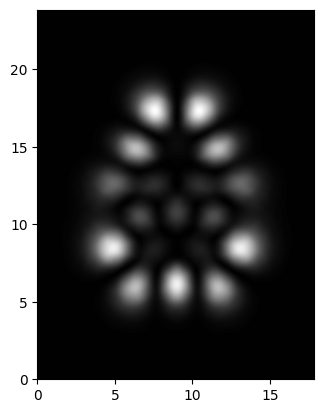

In [32]:
stm_s.plot(2.85,cmap='gray')

<Axes: >

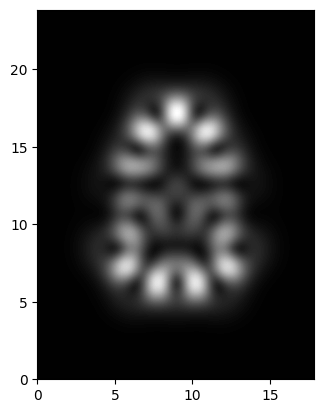

In [33]:
stm_p.plot(2.85,cmap='gray')

In [34]:
brstm = SPMGrid('brstm_triangulene_V1.500.npz','data')

z=3.0000, min=1.8793e-11, max=1.3661e-07, range=1.3660e-07


<Axes: >

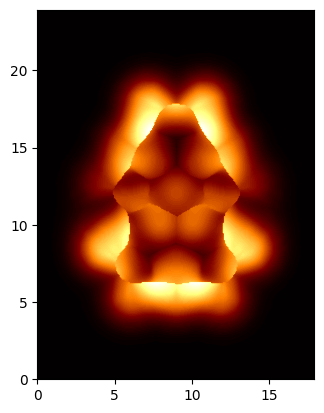

In [35]:
brstm.plot(3,cmap='afmhot',info=True)